<a href="https://colab.research.google.com/github/iotanalytics/IoTTutorial/blob/main/code/preprocessing_and_decomposition/Shapelets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Shaplets**

Shapelets are defined as “subsequences that are in some sense maximally representative of a class”. **[1]**   Assuming a binary classification setting, "a shapelet is discriminant if it is **present** in most series of one class and absent from series of the other class". **[2]**  "Shapelets are a powerful approach for measuring phase-independent similarity between time series; they can occur at any point within a series and offer interpretable results for how matches occur". **[3]**

**References:**


1.   https://www.cs.ucr.edu/~eamonn/shaplet.pdf
2.   https://tslearn.readthedocs.io/en/stable/user_guide/shapelets.html
3.   https://www.sktime.org/en/latest/examples/shapelet_transform.html
4.   https://tslearn.readthedocs.io/en/stable/auto_examples/classification/plot_shapelets.html#sphx-glr-auto-examples-classification-plot-shapelets-py


The equation for determining the presence of a shapelet withing a time series is listed below.  "Where ***L*** is the length (number of timestamps) of shapelet ***s*** and ***x<sub>t→t+L</sub>*** is the subsequence extracted from time series ***x*** that starts at time index ***t*** and stops at ***t+L***. If the above-defined distance is small enough, then shapelet s is supposed to be present in time series ***x***." **[2]**




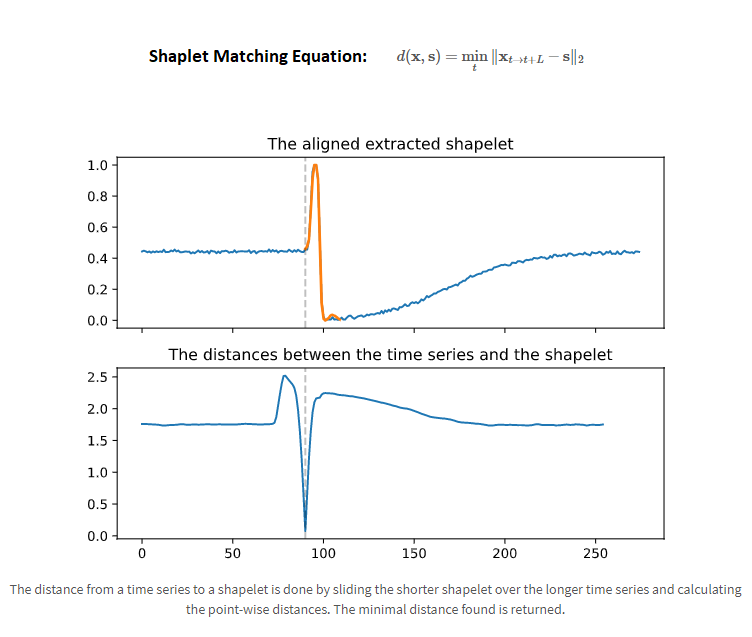

In [ ]:
!pip install tslearn

     |████████████████████████████████| 793 kB 5.1 MB/s 


/usr/local/lib/python3.7/dist-packages/tslearn/shapelets/shapelets.py:357: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  FutureWarning)


Correct classification rate: 1.0


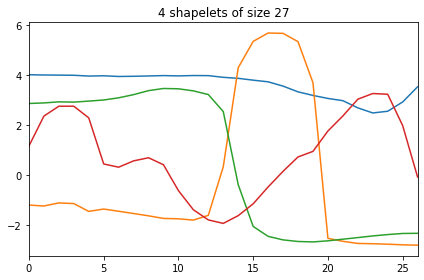

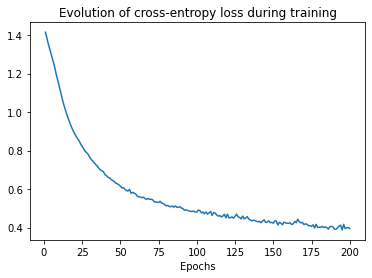

In [ ]:
# From Reference [4]
# Author: Romain Tavenard
# License: BSD 3 clause

import numpy
from sklearn.metrics import accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt

from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import LearningShapelets, \
    grabocka_params_to_shapelet_size_dict
from tslearn.utils import ts_size

# Set seed for determinism
numpy.random.seed(0)

# Load the Trace dataset
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")

# Normalize each of the timeseries in the Trace dataset
X_train = TimeSeriesScalerMinMax().fit_transform(X_train)
X_test = TimeSeriesScalerMinMax().fit_transform(X_test)

# Get statistics of the dataset
n_ts, ts_sz = X_train.shape[:2]
n_classes = len(set(y_train))

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

# Define the model using parameters provided by the authors (except that we
# use fewer iterations here)
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=tf.optimizers.Adam(.01),
                            batch_size=16,
                            weight_regularizer=.01,
                            max_iter=200,
                            random_state=42,
                            verbose=0)
shp_clf.fit(X_train, y_train)

# Make predictions and calculate accuracy score
pred_labels = shp_clf.predict(X_test)
print("Correct classification rate:", accuracy_score(y_test, pred_labels))

# Plot the different discovered shapelets
plt.figure()
for i, sz in enumerate(shapelet_sizes.keys()):
    plt.subplot(len(shapelet_sizes), 1, i + 1)
    plt.title("%d shapelets of size %d" % (shapelet_sizes[sz], sz))
    for shp in shp_clf.shapelets_:
        if ts_size(shp) == sz:
            plt.plot(shp.ravel())
    plt.xlim([0, max(shapelet_sizes.keys()) - 1])

plt.tight_layout()
plt.show()

# The loss history is accessible via the `model_` that is a keras model
plt.figure()
plt.plot(numpy.arange(1, shp_clf.n_iter_ + 1), shp_clf.history_["loss"])
plt.title("Evolution of cross-entropy loss during training")
plt.xlabel("Epochs")
plt.show()

## **Unserpervised Shapelets (u-Shapelets)**

"A recently introduced primitive for time series data mining, unsupervised shapelets (u-shapelets), has demonstrated significant potential for time series clustering. In contrast to approaches that consider the entire time series to compute pairwise similarities, the u-shapelets technique allows considering only relevant subsequences of time series.  Moreover, u-shapelets allow us to bypass the apparent chicken-and-egg paradox of defining relevant with reference to the clustering itself. U-shapelets have several advantages over rival methods. First, they are defined even when the time series are of different lengths; for example, they allow clustering datasets containing a mixture of single heartbeats and multi-beat ECG recordings. Second, u-shapelets mitigate sensitivity to irrelevant data such as noise, spikes, dropouts, etc. Finally, u-shapelets demonstrated ability to provide additional insights into the data." [1]

U-Shaplets use *length-normalized Euclidean distance* for making comparisons. **[2]**   

*   "Compute the distance between two time series of equal length, by simply calculating the Euclidean distance between them. To make our distance measure invariant to scale and offset, we need to z-normalize the time series before computing their Euclidean distance." **[2]**

**u-Shapelet Algorithm Outline:**

Extract u-shapelets.
1.   Use each "window" and slide across timeseries
2.   Calculate gap scores
3.   Calculate distances
4.   Add u-shaplet with max gap to list
5.   Remove u-shapelet and similar shapelets from the time series
6.   The extraction algorithm terminates when the search reveals that for the best u-shapelet choice, the size of DA is just one. 
7.   Return a list of all u-shaplets

Cluster data based on u-shapelets
1.   Create distance map
2.   Pass distance map to clustering alogrithm (could be any)
3.   Using the Rand Index to determine the exit criteria, cluster starting with the best u-shape candidate, then re-cluster with the addition of the next best candidate (and so on) until the clustering becomes stable (RI = 0)




**References:**


1.   https://epubs.siam.org/doi/pdf/10.1137/1.9781611974010.101
2.   https://ieeexplore.ieee.org/document/6413851
3.   https://content.iospress.com/articles/intelligent-data-analysis/ida173717
4.   https://sites.google.com/site/ushapelet/



**Definitions:**

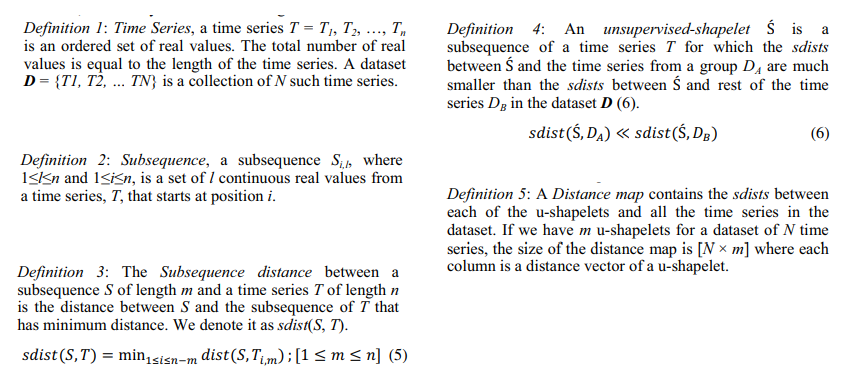

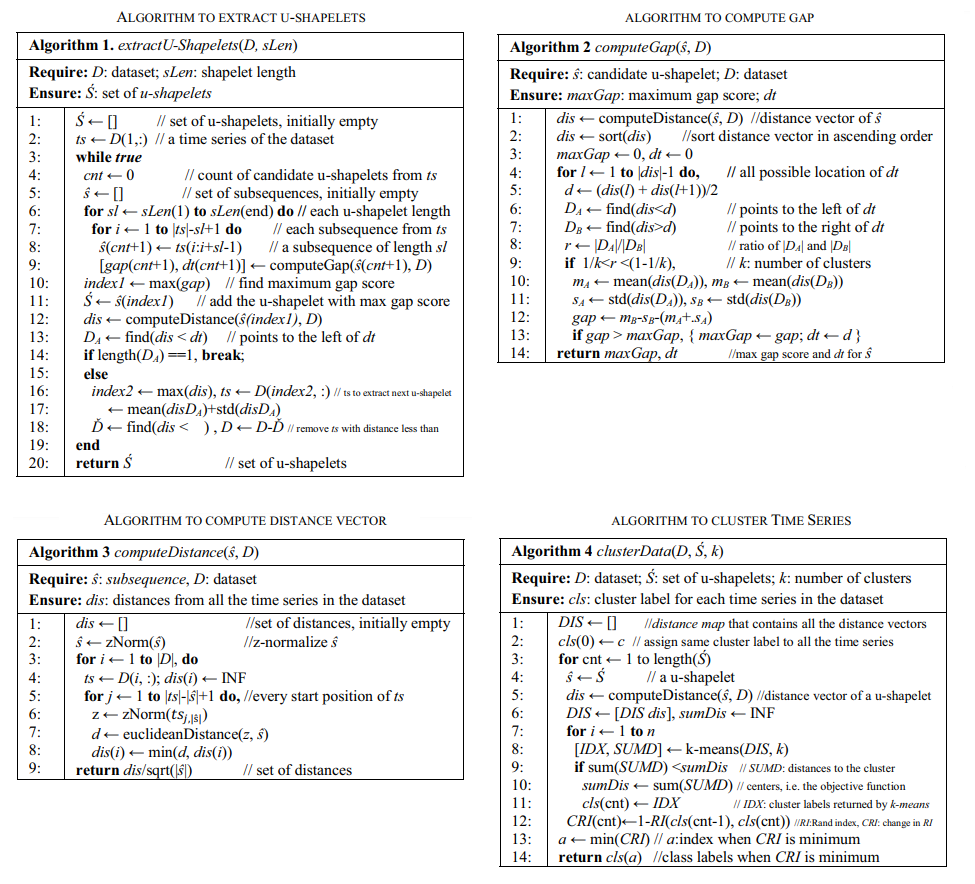